tf.Tensor(b'/nfs/kun2/users/homer/datasets/bridge_data_all/numpy_256/bridge_data_v1/berkeley/toykitchen1/put_small_spoon_from_basket_to_tray/train/out.npy', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int32)


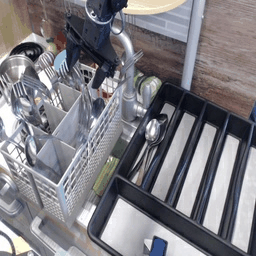

put small spoon from basket to tray


In [1]:
from PIL import Image
import os
import json

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tqdm import tqdm
# to avoid preallocating all GPU memory
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import tensorflow_datasets as tfds

import io
from IPython.display import display, Image as IPyImage

builder = tfds.builder_from_directory(builder_dir='/path/to/bridge_dataset/1.0.0/')

# show the first case only, the gifs are uncompressed(~10MB)! 
for episode_id in range(1):
    ds = builder.as_dataset(split=f"train[{episode_id}:{episode_id + 1}]")
    episode = next(iter(ds))
    frames = [Image.fromarray(step["observation"]["image_0"].numpy()) for step in episode["steps"]] # for fratcal, use image key: ``image''
    print(episode['episode_metadata']['file_path'])
    print(episode['episode_metadata']['episode_id'])
    
    gif_buffer = io.BytesIO()
    frames[0].save(
        gif_buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )
    gif_buffer.seek(0)
    display(IPyImage(data=gif_buffer.getvalue()))
    print([step["language_instruction"].numpy().decode() for step in episode["steps"]][0])

    frames[0].save(
            'example.gif',
            format='GIF',
            save_all=True,
            append_images=frames[1:],
            duration=100,
            loop=0
        )

In [2]:
def make_tf_dict(raw_dict):
    print("Building the reasoning dict...")
    keys = []
    values = []
    instruct_cnt = 0

    for file_name in raw_dict.keys():
        for episode_id in raw_dict[file_name].keys():
            has_instruct = "alt_instruction" in raw_dict[file_name][episode_id]
            instruct_cnt += 1 if has_instruct else 0

            for i,move_primitive in enumerate(raw_dict[file_name][episode_id]["features"]["move_primitive"]):
                keys.append(file_name + "_" + str(episode_id) + "_" + str(i))

                values.append(
                    json.dumps(dict(
                    move_primitive = move_primitive,
                    alt_instruction = raw_dict[file_name][episode_id]["alt_instruction"] if has_instruct else None
                )))
            instruct_cnt += 1 if has_instruct else 0

    print("Example reasoning:", keys[0], values[0])
    print(f"total instructions {instruct_cnt}")

    default_value = json.dumps(dict(move_primitive = None, alt_instruction = None))

    return tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, values), default_value=default_value)

In [3]:
reasoning_dataset_paths = 'path/to/bridge_instruction.json'
reasoning_dataset = {}

with open(reasoning_dataset_paths, "r") as f:
    reasoning_dataset.update(json.load(f))

In [4]:
reasoning_dataset = make_tf_dict(reasoning_dataset)

Building the reasoning dict...
Example reasoning: /nfs/kun2/users/homer/datasets/bridge_data_all/numpy_256/bridge_data_v2/deepthought_folding_table/stack_blocks/19/train/out.npy_43_0 {"move_primitive": "stop", "alt_instruction": {"Caption": "A wooden table with colorful blocks stacked, a wooden base, and a small cup.", "CR": [{"question": "Place the curved wooden structure on the tabletop.", "answer": "I will move the wooden arch to the table."}, {"question": "Adjust the arch made of wood so it sits on the flat surface.", "answer": "I will put the wooden arch on the table."}], "CC": [{"question": "Please set the arch on the table after stacking the colored blocks.", "answer": "I will move the wooden arch to the table now."}, {"question": "Could you bring the wooden structure from the side and place it on the table?", "answer": "I will move the wooden arch to the table."}], "QA": [{"question": "What items are currently on the table?", "answer": "There are colorful blocks and a small cup

In [5]:
# show the first case only, the gifs are uncompressed(~10MB)! 
for episode_id in range(1):
    ds = builder.as_dataset(split=f"train[{episode_id}:{episode_id + 1}]")
    episode = next(iter(ds))
    frames = [Image.fromarray(step["observation"]["image_0"].numpy()) for step in episode["steps"]] # for fratcal, use image key: ``image''

    file_name = episode["episode_metadata"]["file_path"]
    episode_id = episode["episode_metadata"]["episode_id"]

    print(file_name, episode_id)

    traj_len = len(frames)
    
    file_names = tf.repeat(file_name, traj_len)
    episode_ids = tf.as_string(tf.repeat(episode_id, traj_len))
    indices = tf.as_string(tf.range(traj_len))

    hash_key = file_names + "_" + episode_ids + "_" + indices
    reasonings = reasoning_dataset.lookup(hash_key)

    print(reasonings)

tf.Tensor(b'/nfs/kun2/users/homer/datasets/bridge_data_all/numpy_256/bridge_data_v1/berkeley/toykitchen1/put_small_spoon_from_basket_to_tray/train/out.npy', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([b'{"move_primitive": "stop", "alt_instruction": {"Caption": "A kitchen setup with a basket containing various utensils and a tray ready for organization.", "CR": [{"question": "Transfer the small spoon from the container to the tray.", "answer": "I will move the small spoon to the tray."}, {"question": "Place the little spoon from the basket onto the black tray.", "answer": "Okay, I\'ll put the little spoon on the tray."}], "CC": [{"question": "After cleaning the dishes, please take the small spoon from the basket and organize it on the tray.", "answer": "I will place the small spoon onto the tray."}, {"question": "Could you help me by arranging the silverware? Start by moving the small spoon to the tray.", "answer": "I will move the small spoon to the tray."}],